In [2]:
import sys, os, pickle
import pandas as pd
import numpy as np

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt

from ml_models import create_labels, models_stats
from create_datasets import create_nx_datasets, create_table_datasets

/home/laura/anaconda3/envs/graphgym/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Create table datasets

Create table datasets (with and without APOE) for the targets and genes of interest to use as input for non-GNN models.

In [4]:
# Input: type of variant, best network from previous analysis, missense data, diagnosis/metadata
table_dataset = create_table_datasets.adni_data('missense',
                                                  'data/bio_networks/AD_SNAP_PPI_brain.edgelist',
                                                  'data/ADNI/AD_PPI_missense.csv',
                                                  'data/ADNI/ADNIMERGE_metadata.csv')
table_dataset.to_csv(f'data/table_datasets/AD_PPI_missense_ADNI_labeled.csv')

### 2. Baseline models - Logistic Regression only with APOE
Create baseline models, meaning Logistic Regression models for each label only using the number of missense variants in APOE as input.

In [5]:
targets = ['PET', 'PETandDX']

for target in targets:
    
    result_df = pd.DataFrame(columns = ['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])

    data = pd.read_csv('data/table_datasets/AD_PPI_missense_ADNI_labeled.csv', index_col = 0)
    data_wclass = create_labels.label_ADNI(data, target)

    x = data_wclass.drop(columns=['y'])
    x = x['APOE']

    y = data_wclass['y']
    x.index = x.index.str.upper()

    for i in range(10):

        i += 1

        f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
        split = pickle.load(f)
        f.close()

        tr_idx = split['train']
        te_idx = split['valid']

        x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
        y_train, y_test = y[tr_idx], y[te_idx]

        x_train = np.array(x_train).reshape(-1, 1)
        x_test = np.array(x_test).reshape(-1, 1)

        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        logreg = LogisticRegression()
        logreg.fit(x_train_scaled, y_train)

        y_prob = logreg.predict_proba(x_test_scaled)

        y_pred = logreg.predict(x_test_scaled)
        acc = metrics.accuracy_score(y_test, y_pred)
        pre = metrics.precision_score(y_test, y_pred)
        rec = metrics.recall_score(y_test, y_pred)
        f1  = metrics.f1_score(y_test, y_pred)
        auc = metrics.roc_auc_score(y_test, y_prob[:, 1])

        result_df.loc[len(result_df)] = [i, target, 'Only APOE', 'Baseline model', acc, pre, rec, f1, auc]

    result_df.to_csv(f'results/2022_03_baseline_models_{target}.csv', index=False)

### 3. Other non-GNN models
Build non-GNN models (Logistic Regression, SVM with Linear and RBF kernels, and Random Forest) using as input the number of missense variants found in the genes present in AD PPT-Ohmnet network (see Section 2 of this notebook).

In [4]:
for target in ['PET', 'PETandDX']:
    
    print(target)
        
    data = pd.read_csv('data/table_datasets/AD_PPI_missense_ADNI_labeled.csv', index_col = 0)
    data_wclass = create_labels.label_ADNI(data, target) # label dataset with the corresponding label
    data_wclass = data_wclass.loc[:, (data_wclass != 0).any(axis=0)] # delete genes that do not have mutations (all zeroes)
    
    x = data_wclass.drop(columns=['y'])
    y = data_wclass['y']
    x.index = x.index.str.upper()
    
    results = [] # list of lists that stores performance metrics
    
    for i in range(10):

        i += 1
        
        print('Fold', i)
        print('-------------------------------------------------')

        f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
        split = pickle.load(f)
        f.close()

        tr_idx = split['train']
        te_idx = split['valid']

        x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
        y_train, y_test = y[tr_idx], y[te_idx]

        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # Logistic Regression
        logreg = LogisticRegression()
        logreg.fit(x_train_scaled, y_train)
        y_prob_logreg = logreg.predict_proba(x_test_scaled)
        y_pred_logreg = logreg.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet', 'Logistic Regression',
                        metrics.accuracy_score(y_test, y_pred_logreg),
                        metrics.precision_score(y_test, y_pred_logreg),
                        metrics.recall_score(y_test, y_pred_logreg),
                        metrics.f1_score(y_test, y_pred_logreg),
                        metrics.roc_auc_score(y_test, y_prob_logreg[:, 1])])

        # SVM Linear
        svm_lin = SVC(probability=True)
        param_grid_svm_lin = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
        grid_search_svm_lin = GridSearchCV(svm_lin, param_grid_svm_lin, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_svm_lin.fit(x_train_scaled, y_train)
        print(grid_search_svm_lin.best_estimator_)
        y_prob_svm_lin = grid_search_svm_lin.predict_proba(x_test_scaled)
        y_pred_svm_lin = grid_search_svm_lin.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet', 'SVM Linear',
                        metrics.accuracy_score(y_test, y_pred_svm_lin),
                        metrics.precision_score(y_test, y_pred_svm_lin),
                        metrics.recall_score(y_test, y_pred_svm_lin),
                        metrics.f1_score(y_test, y_pred_svm_lin),
                        metrics.roc_auc_score(y_test, y_prob_svm_lin[:, 1])])

        # SVM RBF
        svm_rbf = SVC(probability=True, kernel='rbf')
        param_grid_svm_rbf = [{'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}]
        grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid_svm_rbf, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_svm_rbf.fit(x_train_scaled, y_train)
        print(grid_search_svm_rbf.best_estimator_)
        y_prob_svm_rbf = grid_search_svm_rbf.predict_proba(x_test_scaled)
        y_pred_svm_rbf = grid_search_svm_rbf.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet', 'SVM RBF',
                        metrics.accuracy_score(y_test, y_pred_svm_rbf),
                        metrics.precision_score(y_test, y_pred_svm_rbf),
                        metrics.recall_score(y_test, y_pred_svm_rbf),
                        metrics.f1_score(y_test, y_pred_svm_rbf),
                        metrics.roc_auc_score(y_test, y_prob_svm_rbf[:, 1])])

        # Random Forest
        rf_clf = RandomForestClassifier()
        param_grid = [{'n_estimators': [50, 500, 5000]}]
        grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_rf.fit(x_train, y_train)
        print(grid_search_rf.best_estimator_)
        y_prob_rf = grid_search_rf.predict_proba(x_test)
        y_pred_rf = grid_search_rf.predict(x_test)
        results.append([i, target, 'AD PPT-Ohmnet', 'Random Forest',
                        metrics.accuracy_score(y_test, y_pred_rf),
                        metrics.precision_score(y_test, y_pred_rf),
                        metrics.recall_score(y_test, y_pred_rf),
                        metrics.f1_score(y_test, y_pred_rf),
                        metrics.roc_auc_score(y_test, y_prob_rf[:, 1])])

        print()
        
    results_df = pd.DataFrame(results, columns=['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])
    results_df.to_csv(f'results/2022_03_nonGNN_models_{target}.csv', index=False)

PET
Fold 1
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.01, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=1, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=5000)

Fold 2
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=10, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=1, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=50)

Fold 3
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=1000, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=10, gamma=0.1, probability=True)
Fitting 10 folds for each of 3 candidates,

### 4. Other non-GNN models without APOE
Build non-GNN models (Logistic Regression, SVM with Linear and RBF kernels, and Random Forest) using as input the number of missense variants found in the genes present in AD PPT-Ohmnet network (see Section 2 of this notebook) **but deleting APOE gene from the input**.

In [6]:
for target in ['PET', 'PETandDX']:
    
    print(target)
        
    data = pd.read_csv('data/table_datasets/AD_PPI_missense_ADNI_labeled.csv', index_col = 0)
    data_wclass = create_labels.label_ADNI(data, target) # label dataset with the corresponding label
    data_wclass = data_wclass.loc[:, (data_wclass != 0).any(axis=0)] # delete genes that do not have mutations (all zeroes)
    
    x = data_wclass.drop(columns=['y', 'APOE']) # DELETE APOE GENE !!
    y = data_wclass['y']
    x.index = x.index.str.upper()
    
    results = [] # list of lists that stores performance metrics
    
    for i in range(10):

        i += 1
        
        print('Fold', i)
        print('-------------------------------------------------')

        f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
        split = pickle.load(f)
        f.close()

        tr_idx = split['train']
        te_idx = split['valid']

        x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
        y_train, y_test = y[tr_idx], y[te_idx]

        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # Logistic Regression
        logreg = LogisticRegression()
        logreg.fit(x_train_scaled, y_train)
        y_prob_logreg = logreg.predict_proba(x_test_scaled)
        y_pred_logreg = logreg.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet no APOE', 'Logistic Regression',
                        metrics.accuracy_score(y_test, y_pred_logreg),
                        metrics.precision_score(y_test, y_pred_logreg),
                        metrics.recall_score(y_test, y_pred_logreg),
                        metrics.f1_score(y_test, y_pred_logreg),
                        metrics.roc_auc_score(y_test, y_prob_logreg[:, 1])])

        # SVM Linear
        svm_lin = SVC(probability=True)
        param_grid_svm_lin = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
        grid_search_svm_lin = GridSearchCV(svm_lin, param_grid_svm_lin, cv=10, scoring='roc_auc',
                                           n_jobs = -1, verbose = 3)
        grid_search_svm_lin.fit(x_train_scaled, y_train)
        print(grid_search_svm_lin.best_estimator_)
        y_prob_svm_lin = grid_search_svm_lin.predict_proba(x_test_scaled)
        y_pred_svm_lin = grid_search_svm_lin.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet no APOE', 'SVM Linear',
                        metrics.accuracy_score(y_test, y_pred_svm_lin),
                        metrics.precision_score(y_test, y_pred_svm_lin),
                        metrics.recall_score(y_test, y_pred_svm_lin),
                        metrics.f1_score(y_test, y_pred_svm_lin),
                        metrics.roc_auc_score(y_test, y_prob_svm_lin[:, 1])])

        # SVM RBF
        svm_rbf = SVC(probability=True, kernel='rbf')
        param_grid_svm_rbf = [{'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}]
        grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid_svm_rbf, cv=10, scoring='roc_auc',
                                           n_jobs = -1, verbose = 3)
        grid_search_svm_rbf.fit(x_train_scaled, y_train)
        print(grid_search_svm_rbf.best_estimator_)
        y_prob_svm_rbf = grid_search_svm_rbf.predict_proba(x_test_scaled)
        y_pred_svm_rbf = grid_search_svm_rbf.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet no APOE', 'SVM RBF',
                        metrics.accuracy_score(y_test, y_pred_svm_rbf),
                        metrics.precision_score(y_test, y_pred_svm_rbf),
                        metrics.recall_score(y_test, y_pred_svm_rbf),
                        metrics.f1_score(y_test, y_pred_svm_rbf),
                        metrics.roc_auc_score(y_test, y_prob_svm_rbf[:, 1])])

        # Random Forest
        rf_clf = RandomForestClassifier()
        param_grid = [{'n_estimators': [50, 500, 5000]}]
        grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=10, scoring='roc_auc',
                                      n_jobs = -1, verbose = 3)
        grid_search_rf.fit(x_train, y_train)
        print(grid_search_rf.best_estimator_)
        y_prob_rf = grid_search_rf.predict_proba(x_test)
        y_pred_rf = grid_search_rf.predict(x_test)
        results.append([i, target, 'AD PPT-Ohmnet no APOE', 'Random Forest',
                        metrics.accuracy_score(y_test, y_pred_rf),
                        metrics.precision_score(y_test, y_pred_rf),
                        metrics.recall_score(y_test, y_pred_rf),
                        metrics.f1_score(y_test, y_pred_rf),
                        metrics.roc_auc_score(y_test, y_prob_rf[:, 1])])

        print()
        
    results_df = pd.DataFrame(results, columns=['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])
    results_df.to_csv(f'results/2022_03_nonGNN_models_{target}_noAPOE.csv', index=False)


PET
Fold 1
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.01, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=0.1, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=500)

Fold 2
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=50)

Fold 3
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=1, gamma=0.1, probability=True)
Fitting 10 folds for each of 3 candidate

### 5. Create graph datasets without APOE & graph classification with GNNs

Create the correspoding graph-datasets for each target/label without APOE gene.

We then evaluated and tested the best GNNs obtained for each label as done with the original graph datasets.

Configuration and grid files employed are in the subdirectory [graphgym_files](graphgym_files). The GNNs configuration in this case was the same as the best configuration found with AD PPT-Ohment graph datasets.

We run GraphGym 10 times, with 10 different splits generated by 10-Fold Stratified Cross-Validation.

In [2]:
dataset = 'ADNI'
targets = ['PET', 'PETandDX']
network = 'snap_brain_noAPOE'

for target in targets:
    outdir = f'data/graph_datasets/{target}'

    result_nodes = create_nx_datasets.main('data', dataset, target, 'AD', network, 'missense', None)
    outfile = f'{outdir}/AD_PPI_{network}_missense.pkl'
    print('Resulting dataset saved at:', outfile)
    print()

    with open(outfile, 'wb') as f:
        pickle.dump(result_nodes, f)

Network used: AD snap_brain_noAPOE
# nodes = 28
# edges = 46

Dataset used: ADNI
missense
(28, 808)
Creating samples graphs...
Class: PET. Found 410 positive subjects out of 726
Sample graph used: # nodes = 28 # edges = 46
Density = 0.12169312169312169 Diameter = 6
Resulting dataset saved at: data/graph_datasets/PET/AD_PPI_snap_brain_noAPOE_missense.pkl

Network used: AD snap_brain_noAPOE
# nodes = 28
# edges = 46

Dataset used: ADNI
missense
(28, 808)
Creating samples graphs...
Class: PETandDX. Found 182 positive subjects out of 317
Sample graph used: # nodes = 28 # edges = 46
Density = 0.12169312169312169 Diameter = 6
Resulting dataset saved at: data/graph_datasets/PETandDX/AD_PPI_snap_brain_noAPOE_missense.pkl



### 6. Analyze results: tables and figures

In [4]:
# PET
pet_nonGNN        = pd.read_csv('results/2022_03_nonGNN_models_PET.csv', index_col='fold')
pet_nonGNN_noAPOE = pd.read_csv('results/2022_04_nonGNN_models_PET_noAPOE.csv', index_col='fold')
pet_GNN           = pd.read_csv('results/2022_03_networks_PET.csv', index_col='fold')
pet_GNN_noAPOE    = pd.read_csv('results/2022_04_networks_PET_noAPOE.csv', index_col='fold')
pet_bas           = pd.read_csv('results/2022_03_baseline_models_PET.csv',  index_col='fold')

pet_all = pd.concat([pet_nonGNN, pet_nonGNN_noAPOE, pet_GNN, pet_GNN_noAPOE])
pet_all = pet_all.loc[
    (pet_all['dataset'] == 'Only APOE') |
    (pet_all['dataset'] == 'AD PPT-Ohmnet') | 
    (pet_all['dataset'] == 'AD PPT-Ohmnet no APOE')]

# PET&DX
petdx_nonGNN        = pd.read_csv('results/2022_03_nonGNN_models_PETandDX.csv', index_col='fold')
petdx_nonGNN_noAPOE = pd.read_csv('results/2022_04_nonGNN_models_PETandDX_noAPOE.csv', index_col='fold')
petdx_GNN           = pd.read_csv('results/2022_03_networks_PETandDX.csv', index_col='fold')
petdx_GNN_noAPOE    = pd.read_csv('results/2022_04_networks_PETandDX_noAPOE.csv', index_col='fold')
petdx_bas           = pd.read_csv('results/2022_03_baseline_models_PETandDX.csv',  index_col='fold')

petdx_all = pd.concat([petdx_nonGNN, petdx_nonGNN_noAPOE, petdx_GNN, petdx_GNN_noAPOE])
petdx_all = petdx_all.loc[
    (petdx_all['dataset'] == 'Only APOE') |
    (petdx_all['dataset'] == 'AD PPT-Ohmnet') | 
    (petdx_all['dataset'] == 'AD PPT-Ohmnet no APOE')]

#### Figure 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


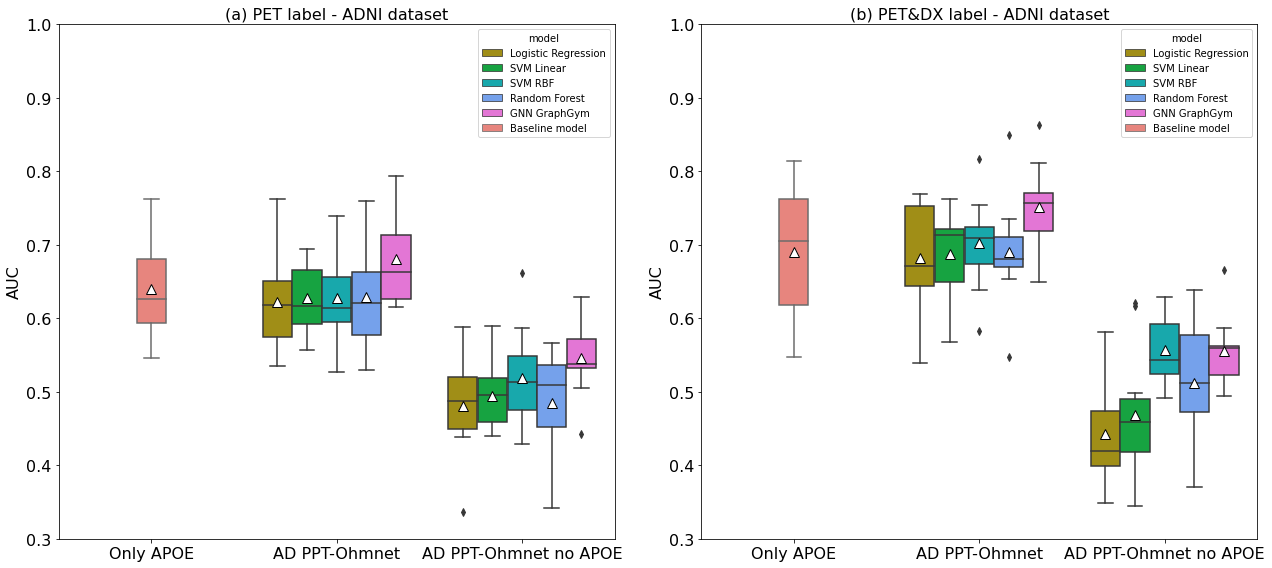

In [5]:
order = ['Only APOE', 'AD PPT-Ohmnet','AD PPT-Ohmnet no APOE']
hue = ['Logistic Regression','SVM Linear', 'SVM RBF', 'Random Forest', 'GNN GraphGym']
hue_bas = ['', '', 'Baseline model', '', '']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 8))
sns.boxplot(x = 'dataset', y = 'auc', hue = 'model', data = pet_all, order = order, hue_order = hue, ax = ax1,
           palette = sns.color_palette(["#B79F00", "#00BA38", "#00BFC4", "#619CFF", "#F564E3"]),
           showmeans = True, meanprops = {"markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})
sns.boxplot(x = 'dataset', y = 'auc', hue = 'model', data = pet_bas, order = order, hue_order = hue_bas, ax = ax1,
           palette = sns.color_palette(['#F8766D', "#F8766D", "#F8766D", "#F8766D", "#F8766D"]),
           showmeans = True, meanprops = {"markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})
sns.boxplot(x = 'dataset', y = 'auc', hue = 'model', data = petdx_all, order = order, hue_order = hue, ax = ax2,
           palette = sns.color_palette(["#B79F00", "#00BA38", "#00BFC4", "#619CFF", "#F564E3"]),
           showmeans = True, meanprops = {"markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})
sns.boxplot(x = 'dataset', y = 'auc', hue = 'model', data = petdx_bas, order = order, hue_order = hue_bas, ax = ax2,
           palette = sns.color_palette(['#F8766D', "#F8766D", "#F8766D", "#F8766D", "#F8766D"]),
           showmeans = True, meanprops = {"markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})

ax1.set_ylim(0.3, 1.0)
ax2.set_ylim(0.3, 1.0)

ax1.set_ylabel('AUC', fontsize=16)
ax2.set_ylabel('AUC', fontsize=16)

ax1.set_xlabel('', fontsize=0)
ax2.set_xlabel('', fontsize=0)

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

ax1.set_title('(a) PET label - ADNI dataset', fontsize=16)
ax2.set_title('(b) PET&DX label - ADNI dataset', fontsize=16)

plt.tight_layout()

# plt.savefig(f'figures/figure3.png', dpi=500)
plt.savefig(f'figures/figure3.eps', dpi=500)

#### p-values against baseline, GNNs and random classification

In [3]:
pet_all = pd.concat([pet_all, pet_bas])
pvalues_bas_pet, pvalues_ran_pet = models_stats.pvalues_nonGNNs(pet_all)

Against baseline:
( ) 7.1252e-01 AD PPT-Ohmnet - Logistic Regression
( ) 6.8956e-01 AD PPT-Ohmnet - SVM Linear
( ) 6.6811e-01 AD PPT-Ohmnet - SVM RBF
( ) 6.3489e-01 AD PPT-Ohmnet - Random Forest
( ) 1.0072e-01 AD PPT-Ohmnet - GNN GraphGym
( ) 9.9997e-01 AD PPT-Ohmnet no APOE - Logistic Regression
( ) 9.9999e-01 AD PPT-Ohmnet no APOE - SVM Linear
( ) 9.9939e-01 AD PPT-Ohmnet no APOE - SVM RBF
( ) 9.9992e-01 AD PPT-Ohmnet no APOE - Random Forest
( ) 9.9871e-01 AD PPT-Ohmnet no APOE - GNN GraphGym

Against GNN:
(*) 3.5778e-02 AD PPT-Ohmnet - Logistic Regression
(*) 2.6525e-02 AD PPT-Ohmnet - SVM Linear
(*) 4.0317e-02 AD PPT-Ohmnet - SVM RBF
( ) 6.2651e-02 AD PPT-Ohmnet - Random Forest
( ) 5.0000e-01 AD PPT-Ohmnet - GNN GraphGym
(*) 1.3357e-02 AD PPT-Ohmnet no APOE - Logistic Regression
(*) 1.5148e-02 AD PPT-Ohmnet no APOE - SVM Linear
( ) 1.8130e-01 AD PPT-Ohmnet no APOE - SVM RBF
(*) 2.7457e-02 AD PPT-Ohmnet no APOE - Random Forest
( ) 5.0000e-01 AD PPT-Ohmnet no APOE - GNN GraphGym

Aga

In [4]:
petdx_all = pd.concat([petdx_all, petdx_bas])
pvalues_bas_petdx, pvalues_ran_petdx = models_stats.pvalues_nonGNNs(petdx_all)

Against baseline:
( ) 5.7567e-01 AD PPT-Ohmnet - Logistic Regression
( ) 5.2998e-01 AD PPT-Ohmnet - SVM Linear
( ) 3.7087e-01 AD PPT-Ohmnet - SVM RBF
( ) 4.9994e-01 AD PPT-Ohmnet - Random Forest
( ) 5.1717e-02 AD PPT-Ohmnet - GNN GraphGym
( ) 1.0000e+00 AD PPT-Ohmnet no APOE - Logistic Regression
( ) 9.9997e-01 AD PPT-Ohmnet no APOE - SVM Linear
( ) 9.9942e-01 AD PPT-Ohmnet no APOE - SVM RBF
( ) 9.9973e-01 AD PPT-Ohmnet no APOE - Random Forest
( ) 9.9947e-01 AD PPT-Ohmnet no APOE - GNN GraphGym

Against GNN:
(*) 1.7280e-02 AD PPT-Ohmnet - Logistic Regression
(*) 1.5860e-02 AD PPT-Ohmnet - SVM Linear
(*) 4.3754e-02 AD PPT-Ohmnet - SVM RBF
(*) 2.7398e-02 AD PPT-Ohmnet - Random Forest
( ) 5.0000e-01 AD PPT-Ohmnet - GNN GraphGym
(*) 3.4273e-04 AD PPT-Ohmnet no APOE - Logistic Regression
(*) 8.2945e-03 AD PPT-Ohmnet no APOE - SVM Linear
( ) 5.3144e-01 AD PPT-Ohmnet no APOE - SVM RBF
( ) 1.0200e-01 AD PPT-Ohmnet no APOE - Random Forest
( ) 5.0000e-01 AD PPT-Ohmnet no APOE - GNN GraphGym

Aga

#### Supplementary Tables

In [11]:
mean_pet = pd.DataFrame()
mean_pet['dataset'] = pet_all['dataset']
mean_pet['model'] = pet_all['model']
mean_pet['mean_acc'] = pet_all.groupby(['dataset', 'model'])['acc'].transform('mean')
mean_pet['std_acc'] = pet_all.groupby(['dataset', 'model'])['acc'].transform('std')
mean_pet['mean_pre'] = pet_all.groupby(['dataset', 'model'])['pre'].transform('mean')
mean_pet['std_pre'] = pet_all.groupby(['dataset', 'model'])['pre'].transform('std')
mean_pet['mean_rec'] = pet_all.groupby(['dataset', 'model'])['rec'].transform('mean')
mean_pet['std_rec'] = pet_all.groupby(['dataset', 'model'])['rec'].transform('std')
mean_pet['mean_f1']  = pet_all.groupby(['dataset', 'model'])['f1'].transform('mean')
mean_pet['std_f1']  = pet_all.groupby(['dataset', 'model'])['f1'].transform('std')
mean_pet['mean_auc'] = pet_all.groupby(['dataset', 'model'])['auc'].transform('mean')
mean_pet['std_auc'] = pet_all.groupby(['dataset', 'model'])['auc'].transform('std')
mean_pet = mean_pet.drop_duplicates()

mean_pet['acc_format'] = round(mean_pet["mean_acc"], 4).map(str) + ' ± ' + round(mean_pet["std_acc"], 4).map(str)
mean_pet['pre_format'] = round(mean_pet["mean_pre"], 4).map(str) + ' ± ' + round(mean_pet["std_pre"], 4).map(str)
mean_pet['rec_format'] = round(mean_pet["mean_rec"], 4).map(str) + ' ± ' + round(mean_pet["std_rec"], 4).map(str)
mean_pet['f1_format']  = round(mean_pet["mean_f1"], 4).map(str) + ' ± ' + round(mean_pet["std_f1"], 4).map(str)
mean_pet['auc_format'] = round(mean_pet["mean_auc"], 4).map(str) + ' ± ' + round(mean_pet["std_auc"], 4).map(str)
mean_pet[['dataset', 'model', 'acc_format', 'pre_format', 'rec_format', 'f1_format', 'auc_format']]

,dataset,model,acc_format,pre_format,rec_format,f1_format,auc_format
fold,,,,,,,
1,AD PPT-Ohmnet,Logistic Regression,0.599 ± 0.0534,0.6331 ± 0.0515,0.722 ± 0.156,0.6644 ± 0.066,0.6229 ± 0.0693
1,AD PPT-Ohmnet,SVM Linear,0.6074 ± 0.0553,0.6549 ± 0.0646,0.7 ± 0.1879,0.6604 ± 0.0688,0.627 ± 0.0493
1,AD PPT-Ohmnet,SVM RBF,0.6006 ± 0.061,0.6206 ± 0.079,0.8683 ± 0.1858,0.7062 ± 0.0506,0.6275 ± 0.0628
1,AD PPT-Ohmnet,Random Forest,0.6197 ± 0.0622,0.6799 ± 0.0612,0.6244 ± 0.1017,0.647 ± 0.0673,0.6291 ± 0.0771
1,AD PPT-Ohmnet no APOE,Logistic Regression,0.5538 ± 0.0176,0.5598 ± 0.0095,0.9805 ± 0.0277,0.7127 ± 0.0147,0.481 ± 0.067
1,AD PPT-Ohmnet no APOE,SVM Linear,0.5607 ± 0.016,0.5631 ± 0.0087,0.9902 ± 0.0236,0.7179 ± 0.0129,0.4942 ± 0.0459
1,AD PPT-Ohmnet no APOE,SVM RBF,0.5593 ± 0.0151,0.5625 ± 0.0086,0.9878 ± 0.0237,0.7168 ± 0.0124,0.5192 ± 0.0726
1,AD PPT-Ohmnet no APOE,Random Forest,0.5524 ± 0.027,0.5602 ± 0.0144,0.9634 ± 0.035,0.7084 ± 0.0202,0.4853 ± 0.0771
1,AD PPT-Ohmnet,GNN GraphGym,0.6362 ± 0.0748,0.6739 ± 0.1139,0.6488 ± 0.1169,0.654 ± 0.1031,0.6801 ± 0.0643


In [6]:
mean_petdx = pd.DataFrame()
mean_petdx['dataset'] = petdx_all['dataset']
mean_petdx['model'] = petdx_all['model']
mean_petdx['mean_acc'] = petdx_all.groupby(['dataset', 'model'])['acc'].transform('mean')
mean_petdx['std_acc'] = petdx_all.groupby(['dataset', 'model'])['acc'].transform('std')
mean_petdx['mean_pre'] = petdx_all.groupby(['dataset', 'model'])['pre'].transform('mean')
mean_petdx['std_pre'] = petdx_all.groupby(['dataset', 'model'])['pre'].transform('std')
mean_petdx['mean_rec'] = petdx_all.groupby(['dataset', 'model'])['rec'].transform('mean')
mean_petdx['std_rec'] = petdx_all.groupby(['dataset', 'model'])['rec'].transform('std')
mean_petdx['mean_f1']  = petdx_all.groupby(['dataset', 'model'])['f1'].transform('mean')
mean_petdx['std_f1']  = petdx_all.groupby(['dataset', 'model'])['f1'].transform('std')
mean_petdx['mean_auc'] = petdx_all.groupby(['dataset', 'model'])['auc'].transform('mean')
mean_petdx['std_auc'] = petdx_all.groupby(['dataset', 'model'])['auc'].transform('std')
mean_petdx = mean_petdx.drop_duplicates()

mean_petdx['acc_format'] = round(mean_petdx["mean_acc"], 4).map(str) + ' ± ' + round(mean_petdx["std_acc"], 4).map(str)
mean_petdx['pre_format'] = round(mean_petdx["mean_pre"], 4).map(str) + ' ± ' + round(mean_petdx["std_pre"], 4).map(str)
mean_petdx['rec_format'] = round(mean_petdx["mean_rec"], 4).map(str) + ' ± ' + round(mean_petdx["std_rec"], 4).map(str)
mean_petdx['f1_format']  = round(mean_petdx["mean_f1"], 4).map(str) + ' ± ' + round(mean_petdx["std_f1"], 4).map(str)
mean_petdx['auc_format'] = round(mean_petdx["mean_auc"], 4).map(str) + ' ± ' + round(mean_petdx["std_auc"], 4).map(str)
mean_petdx[['dataset', 'model', 'acc_format', 'pre_format', 'rec_format', 'f1_format', 'auc_format']]

,dataset,model,acc_format,pre_format,rec_format,f1_format,auc_format
fold,,,,,,,
1,AD PPT-Ohmnet,Logistic Regression,0.6627 ± 0.0798,0.6977 ± 0.0777,0.7424 ± 0.109,0.715 ± 0.0707,0.6825 ± 0.076
1,AD PPT-Ohmnet,SVM Linear,0.6531 ± 0.0541,0.6987 ± 0.0651,0.7319 ± 0.1307,0.7053 ± 0.0463,0.6872 ± 0.0654
1,AD PPT-Ohmnet,SVM RBF,0.669 ± 0.0637,0.7172 ± 0.0779,0.7371 ± 0.1248,0.7174 ± 0.0491,0.7025 ± 0.0638
1,AD PPT-Ohmnet,Random Forest,0.6906 ± 0.0579,0.7414 ± 0.0473,0.7149 ± 0.1135,0.7231 ± 0.0638,0.6901 ± 0.075
1,AD PPT-Ohmnet no APOE,Logistic Regression,0.568 ± 0.0294,0.5737 ± 0.0192,0.9617 ± 0.0455,0.7184 ± 0.0247,0.4425 ± 0.0725
1,AD PPT-Ohmnet no APOE,SVM Linear,0.5586 ± 0.0204,0.5701 ± 0.0158,0.9398 ± 0.0607,0.709 ± 0.0224,0.4687 ± 0.0918
1,AD PPT-Ohmnet no APOE,SVM RBF,0.5711 ± 0.0188,0.5758 ± 0.0145,0.9617 ± 0.0587,0.7197 ± 0.0205,0.5571 ± 0.0481
1,AD PPT-Ohmnet no APOE,Random Forest,0.5679 ± 0.0307,0.576 ± 0.019,0.9339 ± 0.0684,0.7119 ± 0.0309,0.5122 ± 0.0916
1,AD PPT-Ohmnet,GNN GraphGym,0.6992 ± 0.0683,0.7381 ± 0.0688,0.7552 ± 0.1105,0.7408 ± 0.0611,0.7521 ± 0.0589
